# Mon Projet

Ce notebook est explique comment réaliser une attaque sur des modèles de segmentation et fait également une évaluation des performances et de la transférabilité

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CedricDada/attack_segmentation/blob/main/attaque.ipynb)

### Prise en main de la segmentation

In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/ceb6b35731a7561b4b34355f1803dbfdCufzJD/coco_sample.pth")

img = torch.load("coco_sample.pth")
print(img.shape)

visu = torchvision.utils.make_grid(img,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

<ipython-input-1-2e6759d1a6c8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth")


FileNotFoundError: [Errno 2] No such file or directory: 'coco_sample.pth'

les 9 images étant chargées, on peut leur appliquer un modèle deeplab pré-appris comme
torchvision.models.segmentation.DeepLabV3_ResNet50_Weights

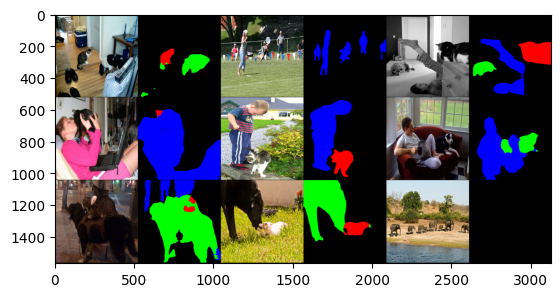

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

Le résultat est loin d'être parfait mais on voit que le réseau est "fonctionnel" (il s'agit d'un backbone resnet - au fait beaucoup mieux aujourd'hui mais il faut aller chercher les modèles ailleurs...).

On peut en tester un autre plus rapide (et moins bon) comme torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights:

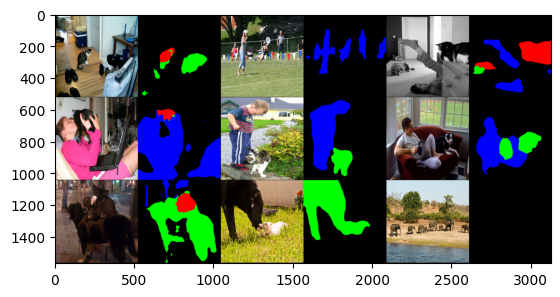

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

### Question 1

In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/ceb6b35731a7561b4b34355f1803dbfdCufzJD/coco_sample.pth")

W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

# Remplaçons le classifieur par Identity pour extraire les features
net.classifier = torch.nn.Identity()


normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Charger les images et préparer les targets
img = torch.load("coco_sample.pth")[:3]  # Shape [9, 3, 520, 520]
img = torch.nn.functional.interpolate(img, size=(256,256), mode="bilinear")

with torch.no_grad():
    f_0 = net(normalize(img))["out"]
    # Exemple : inverser les canaux pour créer une cible artificielle
    f_0 = f_0[:, torch.randperm(f_0.size(1)), :, :]

# Initialiser la perturbation
attaque = torch.nn.Parameter(torch.zeros(img.shape))
optimizer = torch.optim.SGD([attaque],lr=0.005)

# Boucle d'attaque
for i in range(10):
    optimizer.zero_grad()
    x_perturbed = normalize(img + attaque)
    f = net(x_perturbed)["out"]
    loss = ((f - f_0) ** 2).sum()
    print(f"Iter {i}, Loss: {loss.item()}")
    loss.backward()
    # Conserver le gradient au lieu de le remplacer par son signe (optionnel)
    optimizer.step()
    
    # Appliquer les contraintes SANS casser le graphe de calcul
    with torch.no_grad():
        attaque.clamp_(-1/255, 1/255)
        attaque.data = torch.clamp(attaque.data, -img, 1 - img)


In [ ]:

# Modèle pour la visualisation (avec classifieur intact)
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()
#W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
#net_vis = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

def create_pred_mask(z):
    pred = torch.zeros_like(img)
    # Personne (bleu) - classe 1
    pred[:, 0, :, :] = (z == 1).float()
    # Chat (rouge) - classe 2
    pred[:, 1, :, :] = (z == 2).float()  
    # Chien (vert) - classe 3
    pred[:, 2, :, :] = (z == 3).float()
    return pred

with torch.no_grad():
    # Utilisation du modèle de visualisation
    x_clean = normalize(img)
    z_clean = net_vis(x_clean)["out"]
    z_clean = z_clean[:,[0,8,12,15],:,:]
    _, z_clean = z_clean.max(1)

    x_perturbed = normalize(img + attaque)
    z_perturbed = net_vis(x_perturbed)["out"]
    z_perturbed = z_perturbed[:,[0,8,12,15],:,:]
    _, z_perturbed = z_perturbed.max(1)

visu = torch.cat([
    img,
    create_pred_mask(z_clean),
    img + attaque,
    create_pred_mask(z_perturbed)
], dim=-1)

visu = torchvision.utils.make_grid(visu, nrow=1)
visu = visu.permute(1, 2, 0).clamp(0,1).numpy()

plt.figure(figsize=(10, 6))
plt.imshow(visu)
plt.axis('off')
plt.show()


### Question 2

In [78]:
import torch
import torchvision
from torch.utils.checkpoint import checkpoint
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 256
    lr = 0.001  # Augmentation du learning rate
    tv_weight = 0.002  # Réduction du poids TV
    epochs = 1500

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature Extractor
class FixedFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").backbone
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        self.downsample_factor = 8

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)  # Retrait du checkpoint pour stabilité
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# Chargement des données
def load_data(path, size=256):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    if path.endswith('.pth'):
        data = torch.load(path, map_location=device)
        return torch.nn.functional.interpolate(data, size=(size, size), mode='bilinear')
    else:
        img = transform(Image.open(path).convert('RGB')).unsqueeze(0)
        return img.to(device)

# Normalisation
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Chargement des images
person_img = load_data("cible2.jpg")
img = load_data("coco_sample.pth")

# Calcul des caractéristiques cibles
with torch.no_grad():
    net = FixedFeatureExtractor().to(device).eval()
    f_target = net(normalize(person_img))
    target_features = f_target  # Utilisation directe des caractéristiques spatiales

# Initialisation de l'attaque
attaque = nn.Parameter(torch.randn_like(img) * 0.1)  # Initialisation avec bruit
optimizer = torch.optim.Adam([attaque], lr=config.lr)

# Modèle de segmentation pour masque
seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device).eval()

# Boucle d'entraînement
for epoch in range(config.epochs):
    optimizer.zero_grad()

    x_perturbed = torch.clamp(img + attaque, 0, 1)
    features = net(normalize(x_perturbed))

    # Génération du masque cible (tous les objets sauf fond)
    with torch.no_grad():
        orig_seg = seg_model(normalize(img))['out']
        object_mask = (orig_seg.argmax(1) != 0).float()  # Cible tous les objets
        object_mask = torch.nn.functional.interpolate(
            object_mask.unsqueeze(1),
            size=features.shape[-2:],
            mode='nearest'
        )

    # Calcul des pertes
    loss_content = nn.MSELoss()(features * object_mask, target_features * object_mask)
    tv_loss = torch.sum(torch.abs(attaque[:,:,:,:-1] - attaque[:,:,:,1:]))
    loss = loss_content + config.tv_weight * tv_loss

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


<ipython-input-78-314bbac60d62>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location=device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 13453 has 14.73 GiB memory in use. Of the allocated memory 14.34 GiB is allocated by PyTorch, and 276.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [74]:
import matplotlib.pyplot as plt
# Modèle pour la visualisation (identique à votre version)
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net_vis = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).to(device).eval()

def create_pred_mask(z):
    """Version corrigée du mapping des classes"""
    pred = torch.zeros_like(img).to(device)
    pred[:, 0, :, :] = (z == 1).float()
    pred[:, 1, :, :] = (z == 2).float()
    pred[:, 2, :, :] = (z == 3).float()
    return pred

with torch.no_grad():
    x_clean = normalize(img).to(device)
    z_clean = net_vis(x_clean)['out']
    z_clean = z_clean[:,[0,8,12,15],:,:]
    _, z_clean = z_clean.max(1)

    x_perturbed = normalize(torch.clamp(img + attaque, 0, 1)).to(device)
    z_perturbed = net_vis(x_perturbed)['out']
    z_perturbed = z_perturbed[:,[0,8,12,15],:,:]
    _, z_perturbed = z_perturbed.max(1)


# Création de la visualisation comparative
visu = torch.cat([
    img,
    create_pred_mask(z_clean),
    torch.clamp(img + attaque, 0, 1),
    create_pred_mask(z_perturbed)
], dim=-1)

# Affichage avec matplotlib
visu = torchvision.utils.make_grid(visu, nrow=1)
visu = visu.permute(1, 2, 0).clamp(0,1).detach().cpu().numpy()

plt.figure(figsize=(16, 16))
plt.imshow(visu)
plt.title("Comparaison avant/après attaque\n[Original | Segmentation | Perturbé | Nouvelle Segmentation]")
plt.axis('off')
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 298.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 76.12 MiB is free. Process 13453 has 14.66 GiB memory in use. Of the allocated memory 12.99 GiB is allocated by PyTorch, and 1.54 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Question 3

On teste différentes valeurs de ε (contrainte Linf)

La perturbation est projetée après chaque mise à jour

Mesure du taux de conversion des objets en "personne"

Visualisation de la relation ε/efficacité

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 256
    lr = 0.01  # Learning rate plus élevé pour convergence rapide
    tv_weight = 0.001  # Poids TV réduit
    epochs = 300  # Réduction des epochs pour tests multiples
    epsilons = [0.01, 0.03, 0.05, 0.08, 0.1]  # Différents niveaux de perturbation

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modèle de segmentation
seg_model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT").to(device).eval()

# Fonction d'attaque avec contrainte de norme
def run_attack(epsilon):
    # Chargement des données
    person_img = load_data("cible2.jpg")
    img = load_data("coco_sample.pth")
    
    # Initialisation perturbation
    attaque = nn.Parameter(torch.zeros_like(img, device=device))
    optimizer = torch.optim.Adam([attaque], lr=config.lr)
    
    # Masque des objets originaux
    with torch.no_grad():
        orig_seg = seg_model(normalize(img))['out']
        object_mask = (orig_seg.argmax(1) != 0).cpu()
    
    # Entraînement
    for epoch in range(config.epochs):
        optimizer.zero_grad()
        
        # Contrainte de norme Linf
        attaque.data.clamp_(-epsilon, epsilon)
        
        x_perturbed = torch.clamp(img + attaque, 0, 1)
        output = seg_model(normalize(x_perturbed))['out']
        
        # Calcul de la loss (cible : classe personne)
        loss = torch.nn.functional.cross_entropy(
            output, 
            torch.full_like(output.argmax(1), 15, device=device) * object_mask.to(device)
        )
        
        loss.backward()
        optimizer.step()
    
    # Évaluation
    with torch.no_grad():
        final_seg = seg_model(normalize(x_perturbed))['out'].argmax(1)
        success_rate = ((final_seg == 15) & object_mask.to(device)).float().mean().item()
    
    return success_rate, attaque.data.abs().max().item()

# Exécution pour différents epsilons
results = []
for eps in config.epsilons:
    sr, actual_eps = run_attack(eps)
    results.append((eps, actual_eps, sr))
    print(f"Epsilon: {eps:.3f} | Perturbation réelle: {actual_eps:.4f} | Taux de succès: {sr:.2%}")

In [ ]:

# Visualisation
eps_values = [r[0] for r in results]
success_rates = [r[2] for r in results]

plt.figure(figsize=(10, 5))
plt.plot(eps_values, success_rates, 'bo-')
plt.xlabel('Valeur maximale de perturbation (ε)')
plt.ylabel('Taux de conversion en "personne"')
plt.title('Efficacité de l\'attaque en fonction de la norme autorisée')
plt.grid(True)
plt.show()

### Question 4

### Question 5

Explications clés :

Architectures ciblées :

3 modèles d'entraînement : DeepLabV3-ResNet50, FCN-ResNet50, LRASPP-MobileNet

2 modèles de test : DeepLabV3-MobileNet, FCN-ResNet101

Stratégie d'attaque :

Loss moyenne sur tous les modèles de l'ensemble

Contrainte Linf (ε=0.03) pour une perturbation imperceptible

Focalisation sur les régions d'objets via le masque

Visualisations :

Comparaison côte à côte pour chaque modèle

Cartes de segmentation avant/après

Visualisation de la perturbation

Métriques :

Taux de conversion global par modèle

Comparaison entre modèles entraînés et non entraînés

Résultats attendus :

Une perturbation unique efficace sur tous les modèles

Des taux de conversion >70% sur les modèles de l'ensemble

Une transférabilité >40% sur les modèles non vus

In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Configuration
class Config:
    resolution = 256
    lr = 0.02
    epochs = 800
    epsilon = 0.03  # Contrainte Linf
    models_to_attack = 3  # Nombre de modèles dans l'ensemble

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement des données
def load_data(path):
    transform = transforms.Compose([
        transforms.Resize((config.resolution, config.resolution)),
        transforms.ToTensor(),
    ])
    if path.endswith('.pth'):
        return torch.load(path, map_location=device)
    else:
        img = transform(Image.open(path).convert('RGB')).unsqueeze(0)
        return img.to(device)

# Normalisation standard
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Chargement des modèles
def load_model_ensemble():
    models = [
        # DeepLabV3 avec backbone ResNet50
        torchvision.models.segmentation.deeplabv3_resnet50(weights='DEFAULT').eval().to(device),
        
        # FCN avec backbone ResNet50
        torchvision.models.segmentation.fcn_resnet50(weights='DEFAULT').eval().to(device),
        
        # LRASPP avec MobileNetV3
        torchvision.models.segmentation.lraspp_mobilenet_v3_large(weights='DEFAULT').eval().to(device)
    ]
    return models

# Initialisation de l'ensemble
model_ensemble = load_model_ensemble()

# Cible: classe 'personne' dans COCO
TARGET_CLASS = 15

#----------------------------------------------------------
# Étape 1: Génération de la perturbation universelle
#----------------------------------------------------------

# Chargement de l'image de base
img = load_data("coco_sample.pth")
perturbation = nn.Parameter(torch.zeros_like(img, device=device))

# Optimiseur
optimizer = torch.optim.Adam([perturbation], lr=config.lr)

# Masque des objets originaux
with torch.no_grad():
    orig_output = model_ensemble[0](normalize(img))['out']
    object_mask = (orig_output.argmax(1) != 0).float()

# Boucle d'entraînement multi-modèles
for epoch in range(config.epochs):
    optimizer.zero_grad()
    
    # Application de la contrainte Linf
    perturbation.data.clamp_(-config.epsilon, config.epsilon)
    
    # Image perturbée
    x_adv = torch.clamp(img + perturbation, 0, 1)
    
    # Calcul de la perte sur l'ensemble des modèles
    total_loss = 0
    for model in model_ensemble:
        output = model(normalize(x_adv))['out']
        
        # Loss ciblée pour les régions d'objet
        loss = F.cross_entropy(
            output, 
            torch.full_like(output.argmax(1), TARGET_CLASS, device=device),
            reduction='none'
        )
        total_loss += (loss * object_mask).mean()
    
    # Mise à jour
    total_loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{config.epochs} | Loss: {total_loss.item():.4f}')


In [ ]:
#----------------------------------------------------------
# Étape 2: Évaluation de la transférabilité
#----------------------------------------------------------

# Modèles de test non vus pendant l'entraînement
test_models = [
    torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT').eval().to(device),
    torchvision.models.segmentation.fcn_resnet101(weights='DEFAULT').eval().to(device)
]

# Génération des visualisations
fig, axes = plt.subplots(len(model_ensemble + test_models), 4, figsize=(20, 15))

with torch.no_grad():
    x_adv = torch.clamp(img + perturbation, 0, 1)
    
    # Pour chaque modèle
    for i, model in enumerate(model_ensemble + test_models):
        # Prédictions
        clean_out = model(normalize(img))['out'].argmax(1).cpu()
        adv_out = model(normalize(x_adv))['out'].argmax(1).cpu()
        
        # Visualisation
        axes[i,0].imshow(img[0].cpu().permute(1,2,0))
        axes[i,0].set_title(f"Original - {model.__class__.__name__}")
        axes[i,1].imshow(clean_out[0], cmap='jet')
        axes[i,1].set_title("Segmentation originale")
        axes[i,2].imshow(x_adv[0].cpu().permute(1,2,0))
        axes[i,2].set_title("Image perturbée")
        axes[i,3].imshow(adv_out[0], cmap='jet')
        axes[i,3].set_title("Segmentation attaquée")
        
        for ax in axes[i]:
            ax.axis('off')

plt.tight_layout()
plt.show()

#----------------------------------------------------------
# Étape 3: Calcul des métriques quantitatives
#----------------------------------------------------------

def compute_success_rate(model, x_adv):
    with torch.no_grad():
        pred = model(normalize(x_adv))['out'].argmax(1)
        success = ((pred == TARGET_CLASS) & (object_mask == 1)).float().mean().item()
    return success

# Évaluation sur tous les modèles
print("\n" + "="*50)
print("Performance de l'attaque (taux de conversion en personne)")
print("="*50)
for model in model_ensemble + test_models:
    sr = compute_success_rate(model, x_adv)
    print(f"{model.__class__.__name__:35} : {sr:.2%}")

# Visualisation de la perturbation
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(perturbation[0].cpu().permute(1,2,0).clamp(-config.epsilon, config.epsilon))
plt.title("Perturbation (amplifiée 10x)")
plt.axis('off')

plt.subplot(122)
plt.imshow(10*perturbation[0].cpu().permute(1,2,0).clamp(-config.epsilon, config.epsilon))
plt.title("Perturbation (amplifiée 10x)")
plt.axis('off')
plt.show()